# Quelques mots sur l'environnement Python de Kaggle

L'environnement python de Kaggle contient déjà de nombreuses bibliothèques d'analyse utiles :

- Numpy
- Pandas
- Matplotlib
- Seaborn
- SKLearn
- ELI5
- L'environnement est défini par l'image Docker `kaggle/python`. Si vous voulez en savoir plus sur la configuration de l'image cloud sur laquelle vous exécutez votre code, veuillez consulter le repository GitHub.

## Entrée
Il n'y a qu'un seul fichier disponible pour la lecture dans ce notebook, le jeu de données German Credit que nous utiliserons lors de notre session pratique.
Le jeu de données est disponible à `/kaggle/input/german-credit-data-with-risk/german_credit_data.csv`.

## Sauvegarde de données
Vous pouvez écrire jusqu'à **20 Go** dans le répertoire courant kaggle/working qui est conservé entre les sessions. C'est-à-dire que la prochaine fois que vous ouvrez ce notebook et démarrez la session, le fichier sera disponible pour vous.

Vous pouvez également écrire des fichiers temporaires dans /kaggle/temp/, mais ils ne seront pas enregistrés en dehors de la session en cours

Raccourcis utiles
Tous les raccourcis ci-dessous fonctionnent lorsque la cellule cible est sélectionnée (pas lors de l'édition).

- a: pour insérer une cellule au-dessus
- b: pour insérer une cellule en dessous
- dd: pour supprimer une cellule
- m: pour changer la cellule en markdown
- y: pour changer la cellule en code
Pour plus de raccourcis, veuillez consulter ce [notebook](https://www.kaggle.com/naushads/keyboard-shortcuts-for-kaggle-kernels).

In [1]:
#Chargement des données (MongoDB)
# === Chargement des données depuis MongoDB (NoSQL), avec fallback CSV ===
import os
import pandas as pd

DB_NAME = "german_credit_data"
COLL_NAME = "records"

# Contexte d'exécution :
# - Si ton code tourne DANS le conteneur Jupyter : host="mongo"
# - Si tu exécutes en local (kernel conda local) : host="localhost"
MONGO_HOST = os.getenv("MONGO_HOST", "mongo")      # 'mongo' par défaut (docker-compose)
MONGO_PORT = int(os.getenv("MONGO_PORT", "27017")) # 27017 par défaut

def load_from_mongo(host=MONGO_HOST, port=MONGO_PORT, db=DB_NAME, coll=COLL_NAME, limit=None):
    from pymongo import MongoClient
    client = MongoClient(host=host, port=port, serverSelectionTimeoutMS=3000)
    # Vérifie la connexion (lève une exception si Mongo n'est pas accessible)
    client.admin.command("ping")
    cursor = client[db][coll].find({}, {"_id": 0})
    if limit is not None:
        cursor = cursor.limit(int(limit))
    data = list(cursor)
    return pd.DataFrame(data)

try:
    dataset = load_from_mongo()
    print(f"✅ Chargé depuis MongoDB ({MONGO_HOST}:{MONGO_PORT}) | shape={dataset.shape}")
    display(dataset.head())
except Exception as e:
    print(f"⚠️ MongoDB indisponible ({MONGO_HOST}:{MONGO_PORT}) -> fallback CSV. Détail: {e}")
    # Fallback si tu veux encore pouvoir bosser sans Mongo (optionnel)
    for path in ["/home/jovyan/data/german_credit_data.csv", "./data/german_credit_data.csv", "./german_credit_data.csv"]:
        if os.path.exists(path):
            dataset = pd.read_csv(path)
            print(f"✅ Chargé depuis CSV: {path} | shape={dataset.shape}")
            display(dataset.head())
            break
    else:
        raise FileNotFoundError(
            "Ni MongoDB ni CSV accessibles. Vérifie que la base est peuplée (data-loader) "
            "ou place le fichier dans ./data/german_credit_data.csv"
        )


✅ Chargé depuis MongoDB (mongo:27017) | shape=(1000, 11)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


# Contexte: German Credit Rapport

Le jeu de données original contient des entrées avec 20 attributs catégoriels/symboliques préparés par le professeur Hofmann. Dans ce jeu de données, chaque entrée représente une personne qui prend un crédit auprès d'une banque. Chaque personne est classée comme un bon ou un mauvais risque de crédit en fonction de l'ensemble des attributs. Le jeu de données original peut être trouvé [here](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29).

Nous utiliserons une version simplifiée du jeu de données avec seulement **9 attributs** dans notre cours.



In [2]:
### Importation des bibliothèques générales que nous utiliserons dans ce notebook
import numpy as np # algèbre linéaire
import pandas as pd # traitement des données, I/O de fichier CSV (par ex. pd.read_csv)
import seaborn as sns # bibliothèque de tracé qui utilise matplot 
import matplotlib.pyplot as plt # pour tracer certains paramètres dans seaborn

# Reading the dataset
#dataset = pd.read_csv('/home/jovyan/data/german_credit_data.csv')
#print(dataset.head())

In [3]:
dataset.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
# Nettoyer le jeu de données
dataset = dataset.drop('Unnamed: 0', axis='columns')
dataset.head(n=20)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,NaN,NaN,9055,36,education,good
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,28,male,3,own,little,moderate,5234,30,car,bad


## Part 1: Exploring the dataset

1. Explore the dataset features and the target variable
 - How much data do we have?
 - Do we have any missing data? (NaN)
 - What are the types of features in our dataset?
 - How is the distribution of the target variable?

Tip: Check out the [Pandas API](https://pandas.pydata.org/) for functions that can help with data exploration.

Notre jeu de données contient 1000 lignes et 10 colonnes.

Oui, il y a des valeurs manquantes dans les colonnes 'Saving accounts' et 'Checking account'.

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

Les variables numériques du jeu de données sont : Age, Job, Credit amount et Duration. 
Les variables catégorielles sont : Sex, Housing, Saving accounts, Checking account, Purpose et Risk.
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

La variable cible 'Risk' est répartie ainsi : la majorité des individus sont considérés comme un bon risque de crédit 

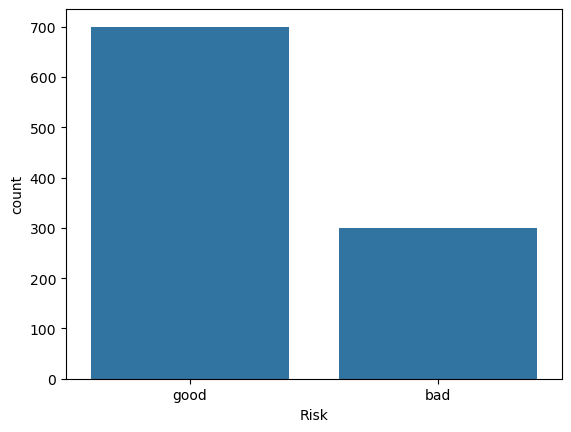

In [5]:
# Combien de données avons-nous?
print(f'Notre jeu de données contient {dataset.shape[0]} lignes et {dataset.shape[1]} colonnes.')

# Avons-nous des données manquantes?
print("\nOui, il y a des valeurs manquantes dans les colonnes 'Saving accounts' et 'Checking account'.\n")
print(dataset.isnull().sum())

# Quels sont les types de caractéristiques (numériques vs catégorielles) ?
print("\nLes variables numériques du jeu de données sont : Age, Job, Credit amount et Duration. \nLes variables catégorielles sont : Sex, Housing, Saving accounts, Checking account, Purpose et Risk.")
print(dataset.dtypes)

# Quelle est la distribution de la variable `Risk`? 
print("\nLa variable cible 'Risk' est répartie ainsi : la majorité des individus sont considérés comme un bon risque de crédit ('good'), tandis qu'une proportion plus faible est classée comme un mauvais risque ('bad').")
print(dataset['Risk'].value_counts())
sns.countplot(data=dataset, x='Risk')
plt.show()

Ecrivez vos observations de la Partie 1 ici:
- Notre jeu de donées a X lignes et Y colonnes
- [...]

# Partie 2: Analyse de la distribution et de la relation des caractéristiques (attributs)

Dans cette partie de la session pratique, nous allons explorer la relation entre les caractéristiques et leur distribution respective dans le jeu de données.
- Avons-nous un jeu de données biaisé?
- Comment certaines caractéristiques sont-elles liées à un bon/mauvais crédit?

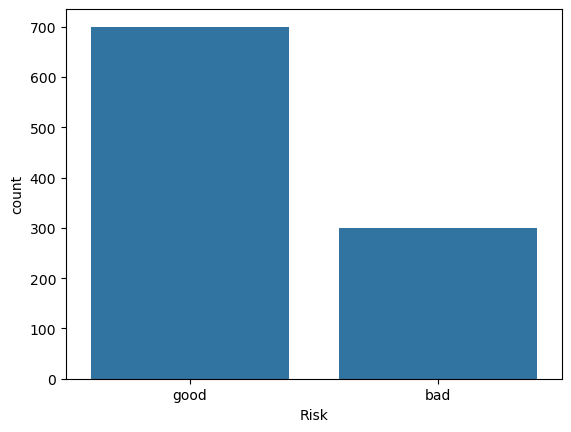

Oui, le jeu de données est biaisé car il y a beaucoup plus de 'good' que de 'bad' risques de crédit.



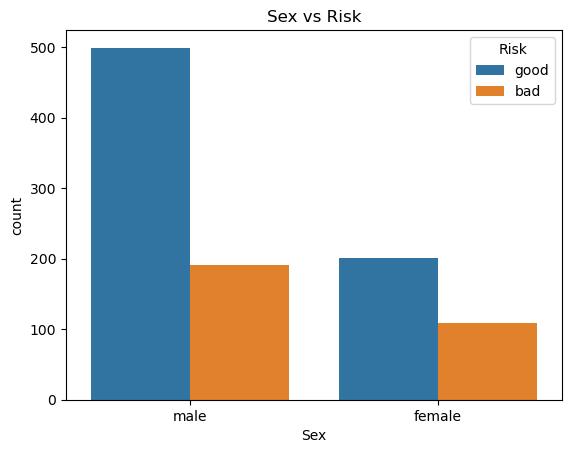

Il semble que les hommes soient plus nombreux à être classés comme 'bad' 
 alors Le sexe semble peu influencer directement le risque, mais on peut observer de petites différences.



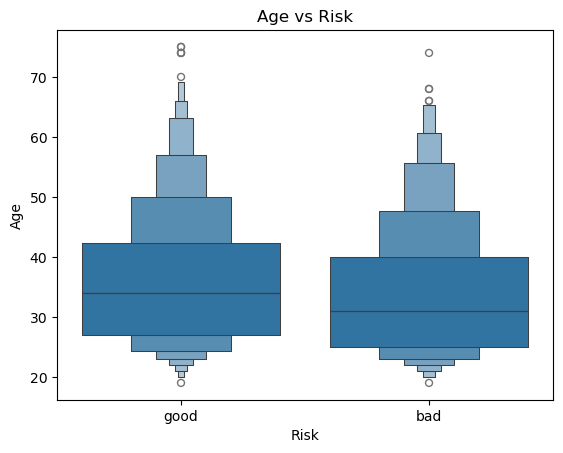

L’âge montre que les personnes plus jeunes ont plus de chance d’être classées en Risk_bad.



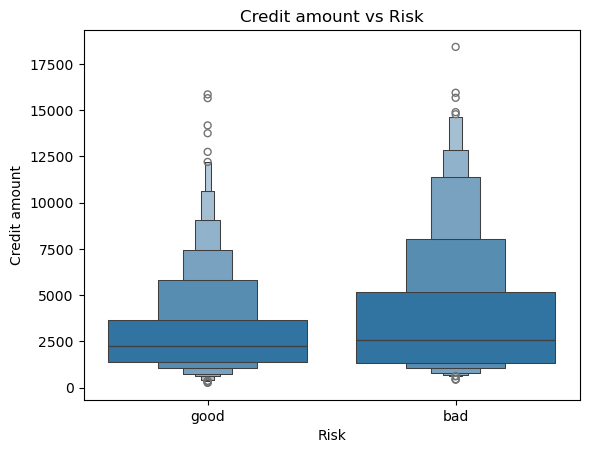

Les personnes avec un montant de crédit plus élevé ont tendance à être classées comme 'bad'.



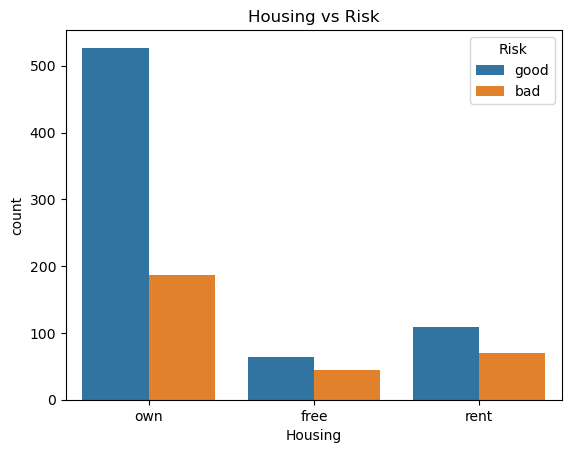

Le type de logement a une influence sur le risque: les propriétaires sont en général plus Risk_good.



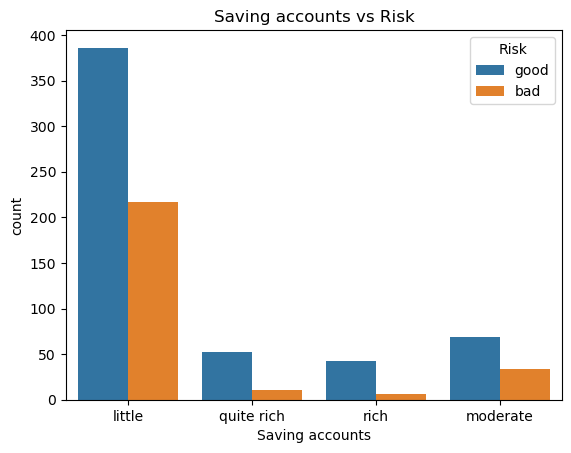

Les personnes avec des comptes d'épargne plus élevés ont tendance à être classées comme 'good'.



In [6]:
#Avons-nous un jeu de données biaisé?

# Vérifier si le dataset est biaisé (distribution de Risk)
sns.countplot(data=dataset, x='Risk')
plt.show()
print("Oui, le jeu de données est biaisé car il y a beaucoup plus de 'good' que de 'bad' risques de crédit.\n")

#Comment certaines caractéristiques sont-elles liées à un bon ou un mauvais risque de crédit?

# Par exemple, la caractéristique `Sex` et `Risk`
sns.countplot(data=dataset, x="Sex", hue="Risk")
plt.title("Sex vs Risk")
plt.show()
print("Il semble que les hommes soient plus nombreux à être classés comme 'bad' \n " \
"alors Le sexe semble peu influencer directement le risque, mais on peut observer de petites différences.\n")

# Par exemple, la caractéristique `Age` et `Risk`
sns.boxenplot(data=dataset, x="Risk", y="Age")
plt.title("Age vs Risk")
plt.show()
print("L’âge montre que les personnes plus jeunes ont plus de chance d’être classées en Risk_bad.\n")

# Par exemple, la caractéristique `Credit amount` et `Risk`
sns.boxenplot(data=dataset, x="Risk", y="Credit amount")
plt.title("Credit amount vs Risk")
plt.show()
print("Les personnes avec un montant de crédit plus élevé ont tendance à être classées comme 'bad'.\n")

# Par exemple, la caractéristique `Housing` et `Risk`
sns.countplot(data=dataset, x="Housing", hue="Risk")
plt.title("Housing vs Risk")
plt.show()
print("Le type de logement a une influence sur le risque: les propriétaires sont en général plus Risk_good.\n")

# Par exemple, la caractéristique `Saving accounts` et `Risk`
sns.countplot(data=dataset, x="Saving accounts", hue="Risk")
plt.title("Saving accounts vs Risk")
plt.show()
print("Les personnes avec des comptes d'épargne plus élevés ont tendance à être classées comme 'good'.\n")



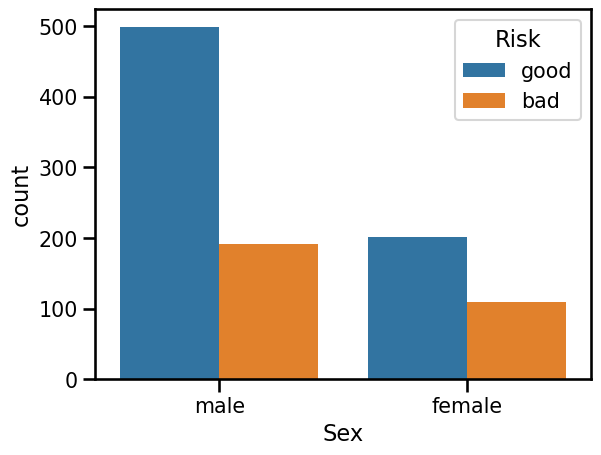

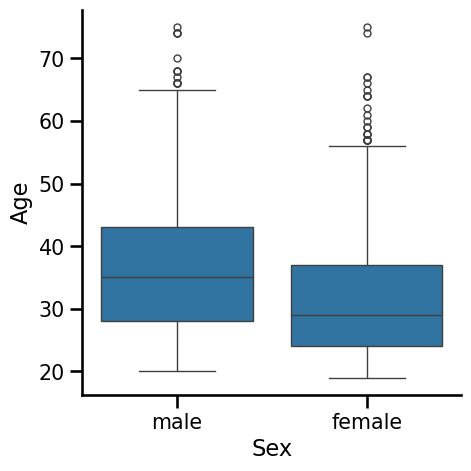

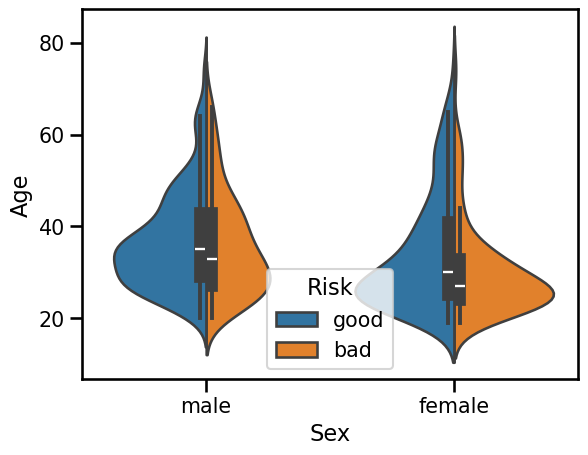

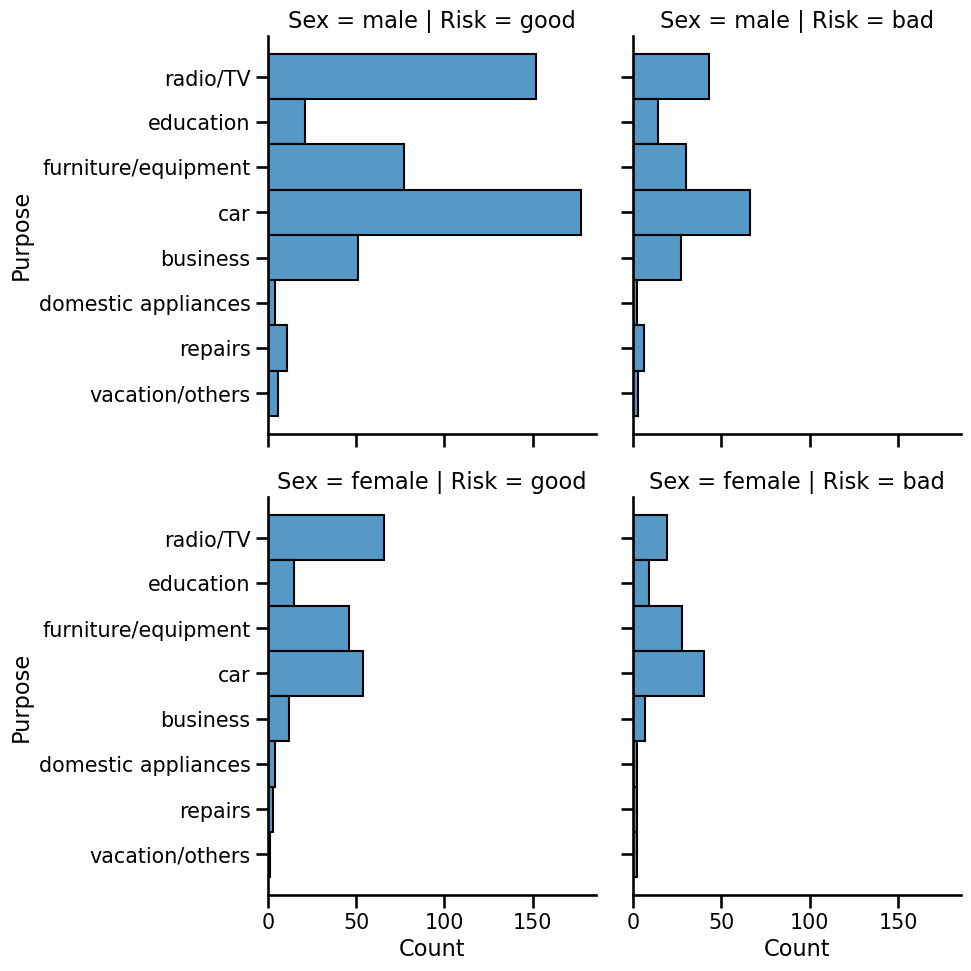

In [7]:
sns.set_context('talk', font_scale=.9)
# Exemple des types d'analyse qui peuvent être effectués

# Count plot nous aide à visualiser le nombre d'éléments par catégorie
sns.countplot(data=dataset, x='Sex', hue='Risk')
plt.show()

# Box plot nous aide à voir la valeur moyenne d'une catégorie "Sex" par "Age" dans notre jeu de données
sns.catplot(data=dataset, x='Sex', y='Age', kind='box')
plt.show()

# Split violin plots nous aide à comparer la distribution à travers une valeur de teinte "Risk"
sns.violinplot(data=dataset, x='Sex', y='Age', hue='Risk', split=True)
plt.show()

# Displot nous aide à visualiser la distribution avec des histogrammes
sns.displot(data=dataset, row='Sex', y='Purpose', col='Risk')
plt.show()

# Expérimentez en analysant d'autres caractéristiques dans le jeu de données!

- Contrôle vs Age vs Risk?
- Compte d'Épargne vs montant de crédit?
- Que demandent les personnes ayant différents types de compte de contrôle (peu, modéré, riche) pour un crédit? 
- ...

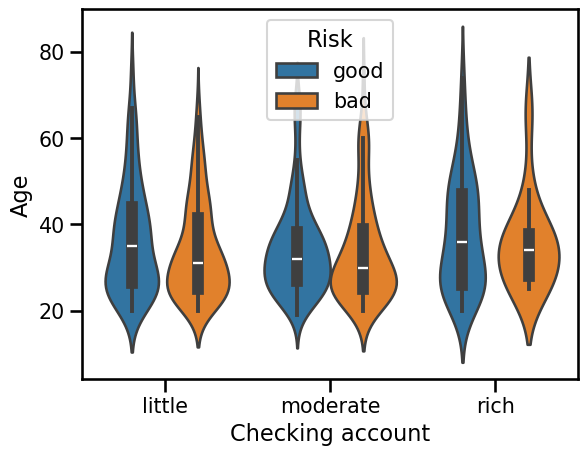

Les clients avec un compte de contrôle faible (“little”) sont souvent plus jeunes.

Parmi eux, on trouve plus de “bad” que dans les catégories “moderate” ou “rich”.



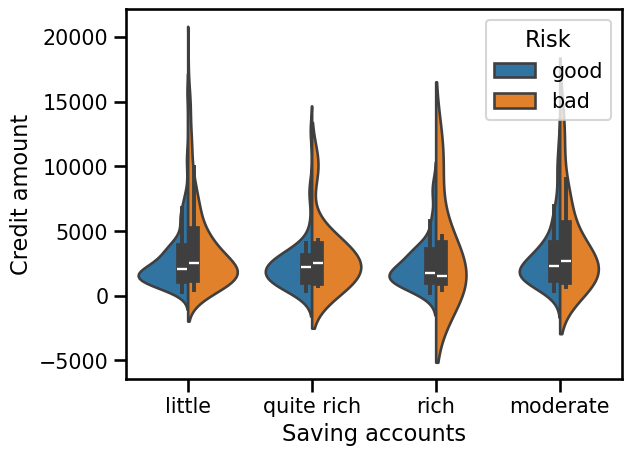

Les personnes sans épargne demandent souvent des crédits plus élevés. 

Le risque de “bad” est plus fréquent quand il n’y a pas ou peu d’épargne. 



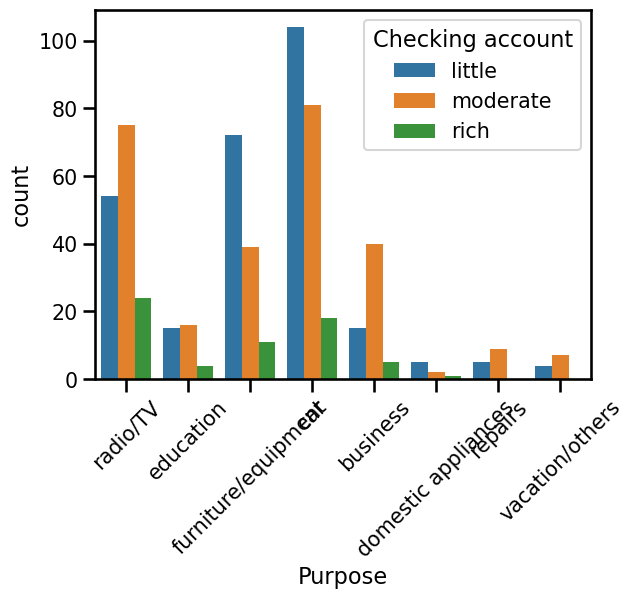

Les personnes avec un compte de contrôle faible demandent plus souvent certains types de prêts (par exemple pour biens de consommation).

À l’inverse, les clients ayant un compte plus solide diversifient davantage leurs demandes de crédits.



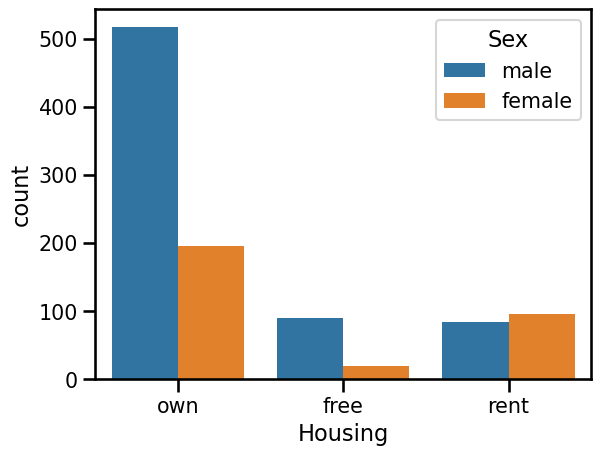

La répartition du logement varie entre hommes et femmes.

Certaines catégories (par exemple, être propriétaire) sont plus fréquentes dans un sexe que dans l’autre.



In [8]:
# Ecrivez votre code ici (vous pouvez réutiliser/copier la plupart du code utilisé au dessus 

#1. Contrôle vs Âge vs Risk ?
sns.violinplot(data=dataset, x='Checking account', y='Age', hue='Risk')
plt.show()
print("Les clients avec un compte de contrôle faible (“little”) sont souvent plus jeunes.\n")
print("Parmi eux, on trouve plus de “bad” que dans les catégories “moderate” ou “rich”.\n")

#2. Compte d’épargne vs montant de crédit ?
sns.violinplot(data=dataset, x='Saving accounts', y='Credit amount', hue='Risk', split=True)
plt.show()
print("Les personnes sans épargne demandent souvent des crédits plus élevés. \n")
print("Le risque de “bad” est plus fréquent quand il n’y a pas ou peu d’épargne. \n")

#3. Que demandent les personnes avec differents compte de contrôle ?
sns.countplot(data=dataset, x='Purpose', hue='Checking account')
plt.xticks(rotation=45)
plt.show()
print("Les personnes avec un compte de contrôle faible demandent plus souvent certains types de prêts (par exemple pour biens de consommation).\n")
print("À l’inverse, les clients ayant un compte plus solide diversifient davantage leurs demandes de crédits.\n")

# Displot nous aide à visualiser la distribution avec des histogrammes
# sns.displot(data=dataset, row='Purpose', y='Credit amount', col='Risk')
# plt.show()

sns.countplot(data=dataset, x='Housing', hue='Sex')
plt.show()
print("La répartition du logement varie entre hommes et femmes.\n")
print("Certaines catégories (par exemple, être propriétaire) sont plus fréquentes dans un sexe que dans l’autre.\n")

# Partie 3. Préparation du jeu de données pour notre modélisation (Ingénierie des caractéristiques) (Ensemble)

Maintenant que nous avons exploré certaines des caractéristiques de notre jeu de données, nous devrions évaluer leur qualité et leur potentiel pour extraire des caractéristiques plus informatives en appliquant des connaissances du domaine, ou en combinant les caractéristiques ensemble.

- Y a-t-il des caractéristiques qui pourraient être mieux représentées?
- Pouvons-nous extraire d'autres caractéristiques à partir de l'ensemble actuel?

In [9]:
dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


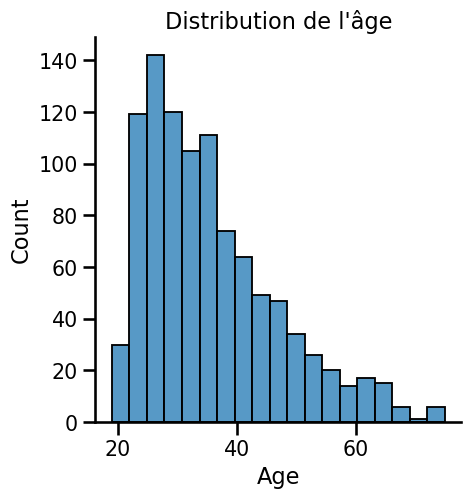

In [10]:
# L'age pourrait-il etre mieux représenté?

# Voyons comment l`age est distribué
sns.displot(dataset['Age'])
plt.title("Distribution de l'âge")
plt.show()

# Divisons l'âge en catégories
interval = (18, 25, 35, 60, 120)
cats = ['Young Adult', 'Adult', 'Senior', 'Elder']
dataset["Age_cat"] = pd.cut(dataset['Age'], interval, labels=cats)


In [11]:
dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,67,male,2,own,NaN,little,1169,6,radio/TV,good,Elder
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,Young Adult
2,49,male,1,own,little,NaN,2096,12,education,good,Senior
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,Senior
4,53,male,2,free,little,little,4870,24,car,bad,Senior


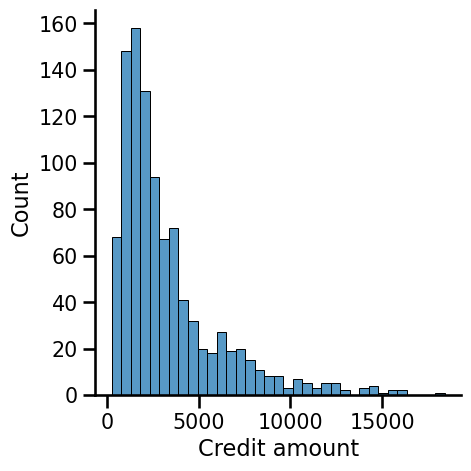

In [12]:
# Le montant du crédit pourrait-il mieux representé?
# Voyons comment le montant du crédit est distribué
sns.displot(dataset['Credit amount'])
plt.show()

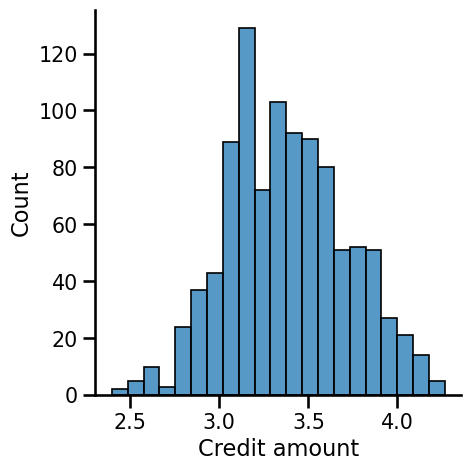

In [13]:
# Une autre façon de représenter les distributions numériques à longue traine est de les transformer
# en utilisant, par exemple, une fonction log
sns.displot(np.log10(dataset['Credit amount']))
plt.show()

# Applique la nouvelle distribution au jeu de données
dataset['Credit amount'] = np.log10(dataset['Credit amount'])

In [14]:
dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,67,male,2,own,NaN,little,3.067815,6,radio/TV,good,Elder
1,22,female,2,own,little,moderate,3.774590,48,radio/TV,bad,Young Adult
2,49,male,1,own,little,NaN,3.321391,12,education,good,Senior
3,45,male,2,free,little,little,3.896636,42,furniture/equipment,good,Senior
4,53,male,2,free,little,little,3.687529,24,car,bad,Senior


In [15]:
# Gérer les valeurs manquantes de Compte d'épargne et compte courant
dataset['Saving accounts'] = dataset['Saving accounts'].fillna('no_inf')
dataset['Checking account'] = dataset['Checking account'].fillna('no_inf')

In [16]:
dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,67,male,2,own,no_inf,little,3.067815,6,radio/TV,good,Elder
1,22,female,2,own,little,moderate,3.774590,48,radio/TV,bad,Young Adult
2,49,male,1,own,little,no_inf,3.321391,12,education,good,Senior
3,45,male,2,free,little,little,3.896636,42,furniture/equipment,good,Senior
4,53,male,2,free,little,little,3.687529,24,car,bad,Senior


### Encodage des caractéristiques catégorielles

Les caractéristiques catégorielles posent un problème aux modèles d'apprentissage automatique:
- Comment représenter les caractéristiques catégorielles comme Logement = {propriétaire, locataire}?

**Solution 1 - Encodage numérique:** Nous pourrions les représenter en utilisant des valeurs numériques - Logement = {propriétaire = 1, locataire = 2}

| Housing | 
| -- |
| 1 | 
| 2 | 

- Le problème de cette représentation est qu'elle suppose une relation ordonnée:
 - est-ce que "propriétaire" vient avant "locataire"? Cette question a-t-elle même un sens?

**Solution 2 - Encodage One-Hot:** Au lieu de représenter Logement = {propriétaire = 1, locataire = 2}, nous transformons Logement en une matrice:


| Housing_own | Housing_free | 
| -- | -- |
| 1 | 0 | 
| 0 | 1 | 

In [17]:
# Scikit-learn a un encodeur OneHot adéquat que nous pourrions utiliser dans notre pipeline. Cependant,
# pour des raisons d'exploration, l'encodeur OneHot de Scikit-learn ne garde pas trace de la valeur

def one_hot_encoder(df, column_name, exclude_col = False):
    merged_df = df.merge(pd.get_dummies(df[column_name], drop_first=False, prefix=column_name), left_index=True, right_index=True)
    if exclude_col:
        del merged_df[column_name] # Exclure la colonne d'origine
    return merged_df


In [18]:
# Avant d'apliquer l'encodage OneHot
dataset.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk', 'Age_cat'],
      dtype='object')

In [19]:
# Comme le changement va être plus signifiant. On va copier le dataframe et sauvegarder dans une autre variable (on peut toujours comparer le deux)  
dataset_ready = dataset.copy()

category_features = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk', 'Age_cat']

for cat in category_features:
    dataset_ready = one_hot_encoder(dataset_ready, cat, exclude_col=True)

In [20]:
# Avant de l'Encodage OneHot 
dataset_ready.columns

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male',
       'Housing_free', 'Housing_own', 'Housing_rent', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_no_inf',
       'Saving accounts_quite rich', 'Saving accounts_rich',
       'Checking account_little', 'Checking account_moderate',
       'Checking account_no_inf', 'Checking account_rich', 'Purpose_business',
       'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Risk_bad', 'Risk_good',
       'Age_cat_Young Adult', 'Age_cat_Adult', 'Age_cat_Senior',
       'Age_cat_Elder'],
      dtype='object')

In [21]:
dataset_ready.head()

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_bad,Risk_good,Age_cat_Young Adult,Age_cat_Adult,Age_cat_Senior,Age_cat_Elder
0,67,2,3.067815,6,False,True,False,True,False,False,...,False,True,False,False,False,True,False,False,False,True
1,22,2,3.774590,48,True,False,False,True,False,True,...,False,True,False,False,True,False,True,False,False,False
2,49,1,3.321391,12,False,True,False,True,False,True,...,False,False,False,False,False,True,False,False,True,False
3,45,2,3.896636,42,False,True,True,False,False,True,...,True,False,False,False,False,True,False,False,True,False
4,53,2,3.687529,24,False,True,True,False,False,True,...,False,False,False,False,True,False,False,False,True,False


# Partie 4. Prédiction du risque (Modelling)

Tout d'abord, nous allons diviser le jeu de données en:
- Caractéristiques (X) et variable cible (y)
- Ensemble d'entraînement (75%) et ensemble de test (25%)

In [22]:
# Importation des bibliothèques que nous utiliserons dans cette partie de la classe
from sklearn.model_selection import train_test_split, KFold, cross_val_score # pour séparer les données
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
 #Pour évaluer notre modèle

from sklearn.model_selection import GridSearchCV

# Modèles d'algorithmes à comparer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
# TODO: Ajouter ici tout nouveau modèle que vous souhaitez essayer (ANN, etc.)

# Création des variables X et y
dataset_ready_x = dataset_ready.drop(['Risk_bad', 'Risk_good', 'Age', 'Sex_male'], axis='columns')
X = dataset_ready_x.values
feature_names = dataset_ready_x.columns

y = dataset_ready['Risk_bad'].values

# Séparation de X et y en version d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

Ensuite, nous expérimenterons avec plusieurs modèles pour choisir quelques-uns appropriés. Voici les modèles que nous allons expérimenter:
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
- [Support Vector Machine Classifier (SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
- [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn)
- Plus de classificateurs peuvent être trouvés [ici](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)


In [23]:
# Expérimentez différents modèles 
classifier = LogisticRegression(solver='liblinear')
# classifier = KNeighborsClassifier()
# classifier = DecisionTreeClassifier()
# classifier = GaussianNB()
# classifier = RandomForestClassifier()
# classifier = SVC()
# classifier = MLPClassifier()
# classifier = XGBClassifier()
# classifier = [...]

classifier_name = classifier.__class__.__name__

scoring_type = 'accuracy'
kfold = KFold(n_splits=5, random_state=42, shuffle=True) # Assurez que toutes les méthodes sont évaluées dans les mêmes données

score = cross_val_score(classifier, X_train, y_train, cv=kfold, scoring=scoring_type)
print(f'Average {scoring_type} performance of the {classifier_name} model = {np.mean(score)}')

Average accuracy performance of the LogisticRegression model = 0.7293333333333333


# Partie 6a. Évaluation des performances des modèles - Prédiction de l'ensemble de test
Nous avons vu que de nombreux modèles ont une bonne précision dans nos données d'entraînement. **Mais à quel point nos modèles sont-ils réellement bons?**

Regardons à quel point notre modèle prédit les données de test non vues.

In [24]:
# Test la qualité de la prédiction du modèle 

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Montre le résultat
print(f"Accuracy of our model's prediction {accuracy_score(y_test,y_pred)}")

Accuracy of our model's prediction 0.736


In [25]:
# Prevu
print(f'Credit prevu pour le premier 5 utilisateur a le jeu de données {classifier.predict(X_test[0:5])}')

# Actuel
print(f'Actuel données {y_test[0:5]}')

Credit prevu pour le premier 5 utilisateur a le jeu de données [ True False False False False]
Actuel données [ True False False False False]


# Part 6b. L'Évaluation de performance du modèle - Configuration des modèles de référence

Exémple de modèles de référence:
- **La plus fréquente** : Comparez avec un modèle qui prévoit toujours un "bon" risque
- **Uniforme** : Comparez avec un modèle qui prévoit 50/50 bon et mauvais risque (jet de pièce)
- **Stratifié** : Comparez avec un modèle qui prévoit 70% de bon et 30% de mauvais (au hasard)

In [26]:
from sklearn.dummy import DummyClassifier

strategies = ['most_frequent', 'uniform', 'stratified']

for strategy in strategies:

    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X_train, y_train)

    #Testing the dummy model 
    y_pred = dummy_clf.predict(X_test)

    # Check the obtained results
    print(f'Performance du modèle de référence {strategy}, Accuracy = {accuracy_score(y_test,y_pred)} ')

Performance du modèle de référence most_frequent, Accuracy = 0.712 
Performance du modèle de référence uniform, Accuracy = 0.5 
Performance du modèle de référence stratified, Accuracy = 0.608 


# Partie 7. Réévaluation des performances des modèles - Exploration d'autres métriques de performance

Essayons d'évaluer notre modèle en utilisant d'autres métriques de performance:
- Précision
- Rappel
- Score F1 (moyenne harmonique entre la précision et le rappel)

In [27]:
# Testez la qualité de la précision du modéle 
y_pred = classifier.predict(X_test)

# Verifiez les resultats
print(f"""Performance of our choosen model: 
      \t Accuracy = {accuracy_score(y_test, y_pred)} 
      \t Precision = {precision_score(y_test,y_pred)} 
      \t Recall = {recall_score(y_test, y_pred)} 
      \t F1 = {f1_score(y_test, y_pred)}""")

# print(classification_report(y_test, y_pred))
        
strategies = ['most_frequent', 'uniform', 'stratified']

print(f'\nDUMMY Classifiers (Baseline)')
for strategy in strategies:

    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X_train, y_train)

    # Le modèle de référence
    y_pred_dummy = dummy_clf.predict(X_test)

    # Vérification des résultats
    print(f"""Performance of {strategy} baseline: 
          Accuracy = {accuracy_score(y_test, y_pred_dummy)} 
          Precision = {precision_score(y_test,y_pred_dummy)} 
          Recall = {recall_score(y_test, y_pred_dummy)} 
          F1 = {f1_score(y_test, y_pred_dummy)}""")

Performance of our choosen model: 
      	 Accuracy = 0.736 
      	 Precision = 0.5625 
      	 Recall = 0.375 
      	 F1 = 0.45

DUMMY Classifiers (Baseline)
Performance of most_frequent baseline: 
          Accuracy = 0.712 
          Precision = 0.0 
          Recall = 0.0 
          F1 = 0.0
Performance of uniform baseline: 
          Accuracy = 0.528 
          Precision = 0.2982456140350877 
          Recall = 0.4722222222222222 
          F1 = 0.3655913978494624
Performance of stratified baseline: 
          Accuracy = 0.552 
          Precision = 0.25 
          Recall = 0.2777777777777778 
          F1 = 0.2631578947368421


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


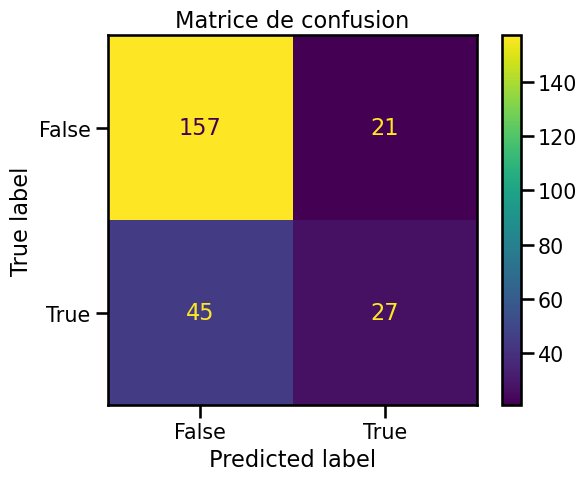

In [28]:
 #Obtenir les prédictions
y_pred = classifier.predict(X_test)

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matrice de confusion")
plt.show()

# Partie 8. Amélioration du modèle (Optionnel)

In [ ]:
# Configuration des paramètres du modèle
param_grid = {"penalty": ['none', 'l2', 'l1', 'elasticnet'],
               "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               "max_iter": [100, 300]}

# Création du modèle
model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
best_model = LogisticRegression(penalty='none', solver='sag', max_iter=300)

# Faire 
best_model.fit(X_train, y_train)

# Verifier la qualité da la prédiction du modèle
y_pred = best_model.predict(X_test)

# Vérification des résultats
print(f1_score(y_test,y_pred))
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Partie 9. Explication du modèle

## Quelles sont les caractéristiques les plus importantes?

Nous mesurons l'importance d'une caractéristique en calculant l'augmentation de l'erreur de prédiction du modèle après **permutation de la caractéristique** (a.k.a. feature permutation importance). 
- Une caractéristique est "importante" si le mélange de ses valeurs augmente l'erreur du modèle, car dans ce cas le modèle a compté sur la caractéristique pour la prédiction. 
- Une caractéristique est "inimportant" si le mélange de ses valeurs laisse l'erreur du modèle inchangée, car dans ce cas le modèle a ignoré la caractéristique pour la prédiction.

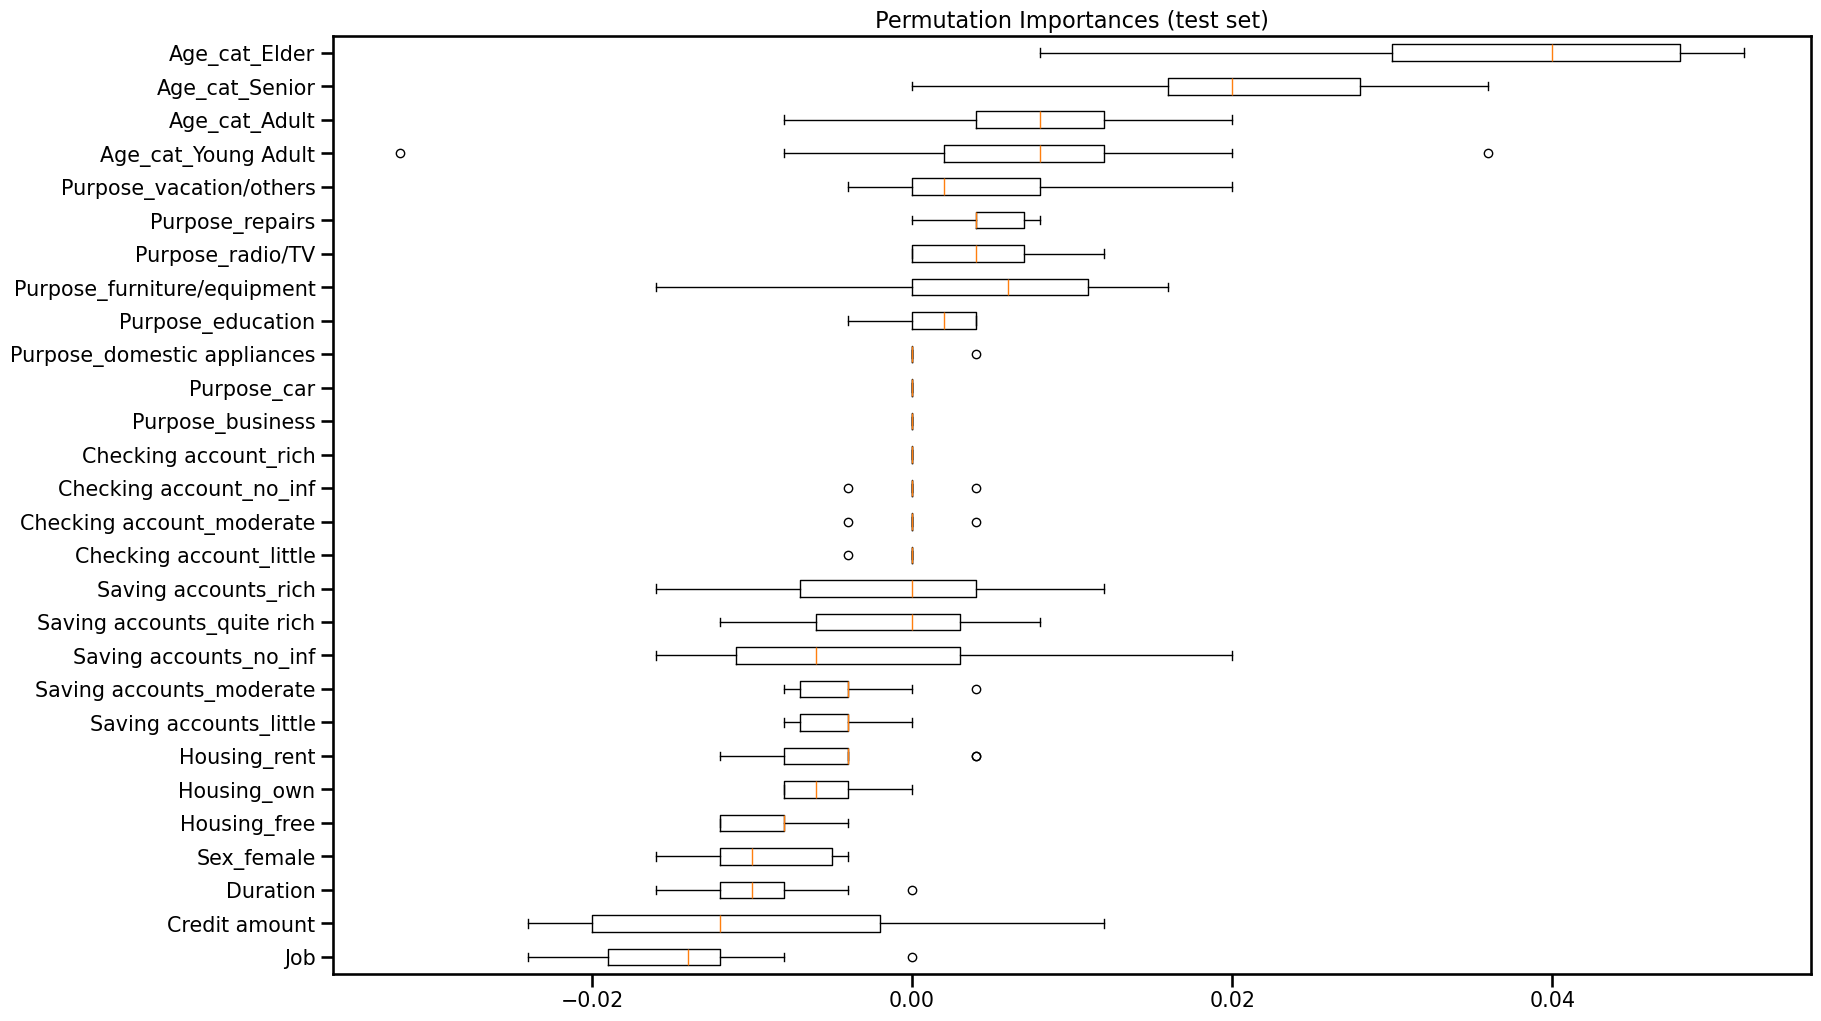

In [32]:
from sklearn.inspection import permutation_importance

# Permutation importance method (test set)
result = permutation_importance(
    classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=feature_names
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

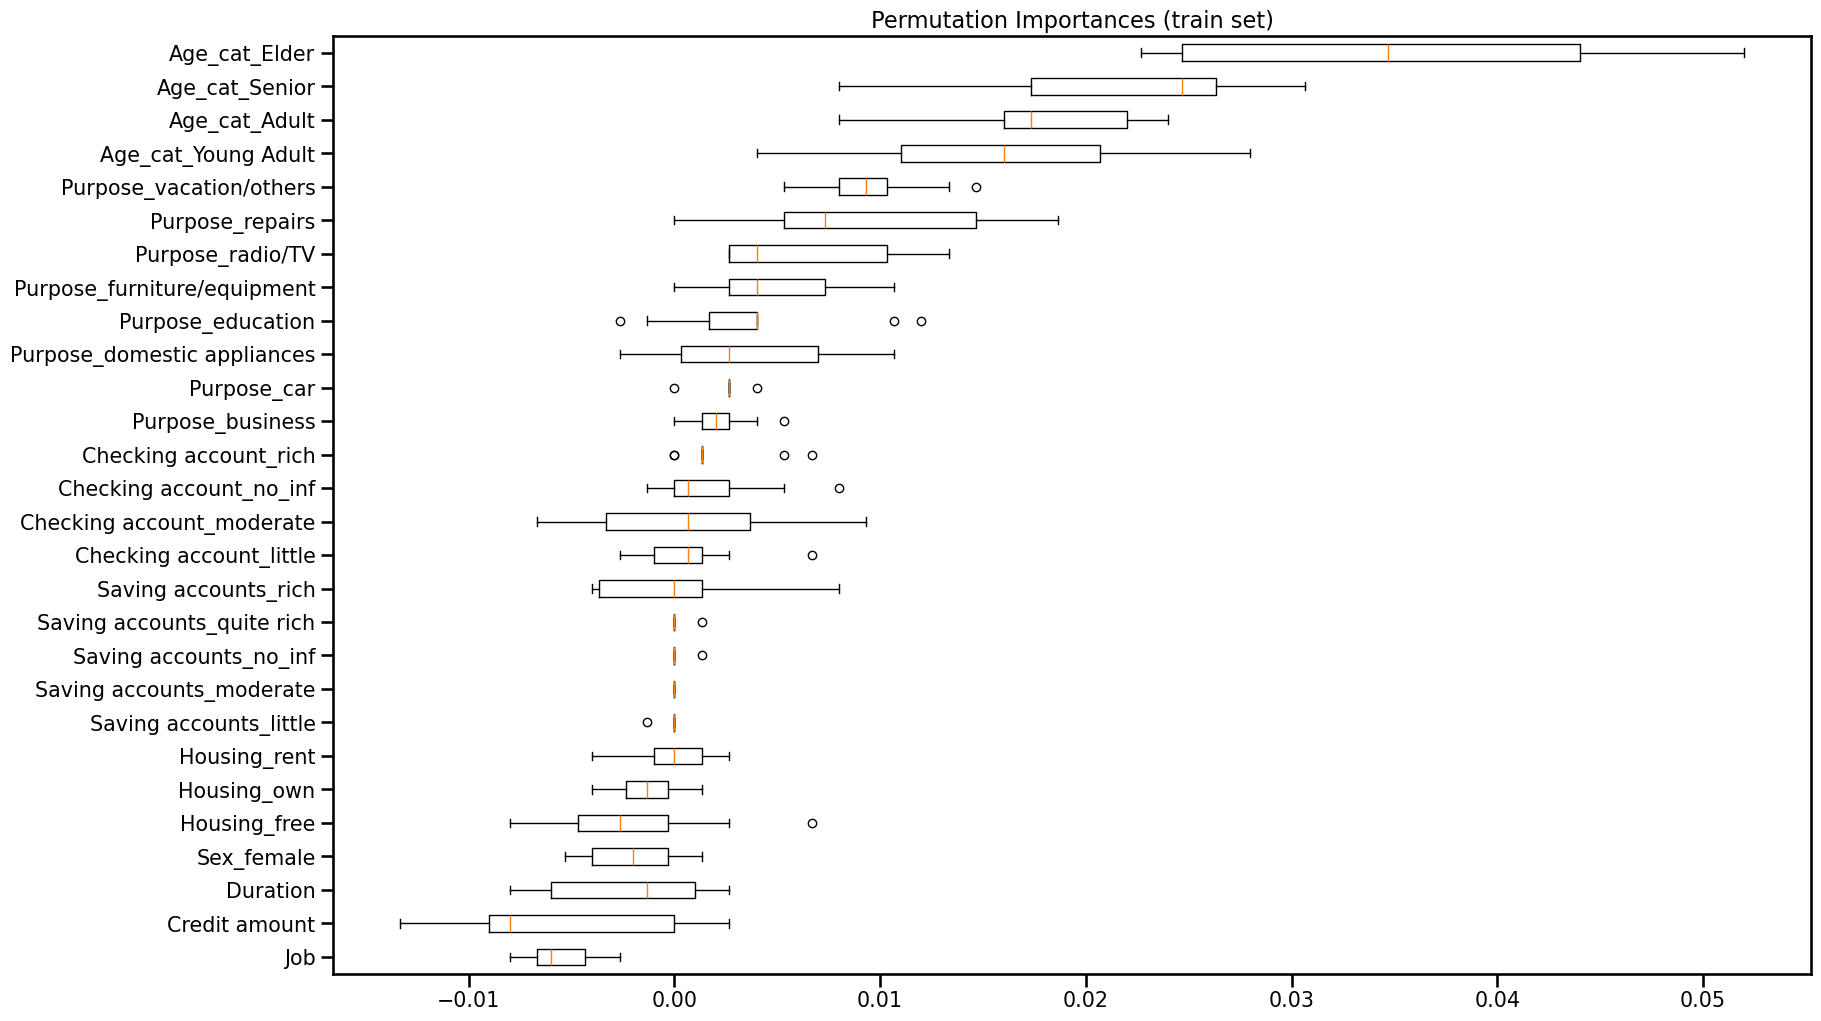

In [33]:
# Permutation importance method (train set)
result = permutation_importance(
    classifier, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=feature_names
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

### Exploration de l'effet de chaque caractéristique

Les étapes suivantes utilisent la bibliothèque ELI5 qui **ne fonctionne pas** avec les classificateurs suivants:
- GaussianNB
- MLPClassifier
- XGBoost (conflit de version de dépendance)

In [34]:
import eli5

eli5.show_weights(classifier, feature_names=feature_names.values, top=100)

Weight?,Feature
+0.615,Checking account_little
+0.553,Age_cat_Young Adult
+0.296,Purpose_education
+0.295,Sex_female
+0.294,Saving accounts_little
+0.287,Checking account_moderate
+0.174,Job
+0.172,Housing_free
+0.150,Purpose_repairs
+0.103,Saving accounts_moderate


### Exploration de la raison pour laquelle le modèle prédit certaines classes

Maintenant que nous avons exploré les caractéristiques les plus importantes du modèle, nous pouvons également essayer d'expliquer **pourquoi** le modèle prédit certaines classes pour certains enregistrements.


In [35]:
classifier.predict(X_test[2:3])

array([False])

In [36]:
eli5.show_prediction(classifier, X_test[2], feature_names=feature_names.values, show_feature_values=True)